In [66]:
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import gymnasium as gym
from source.algorithms import FarmAgentSarsaVFA, FarmAgentMCVFA
import source.config as config
import source.farm_env # Import necessary to register the gym environment

In [67]:
MC_weights = np.load(r'data\MCVFA\delta^years-greedy-50k\weights.npy')
MC_weights = torch.tensor(MC_weights, requires_grad=True)

In [68]:
env = gym.make(id='FarmEnv-v0',
                initial_budget = config.INITIAL_BUDGET,
                sheep_cost = config.SHEEP_COST,
                wheat_cost = config.WHEAT_COST,
                wool_price = config.WOOL_PRICE,
                wheat_price = config.WHEAT_PRICE,
                max_years = config.MAX_YEARS,
                wool_fixed_cost = config.WOOL_FIXED_COST,
                storm_probability = config.STORM_PROBABILITY,
                incest_penalty = config.INCEST_PENALTY,
                )

In [69]:
learning_rate = 0.001
n_episodes = 500_000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

MC_vfa_agent = FarmAgentMCVFA(
    environment=env, learning_rate=learning_rate, epsilon=start_epsilon, epsilon_decay=epsilon_decay, final_epsilon=final_epsilon, gamma=.95
)

SARSA_vfa_agent = FarmAgentSarsaVFA(
    environment=env, learning_rate=learning_rate, epsilon=start_epsilon, epsilon_decay=epsilon_decay, final_epsilon=final_epsilon, gamma=.95
)

In [75]:
MC_vfa_agent.w = MC_weights

In [95]:
trial_state = {'budget': 2, 'sheep_count': 0, 'bought_sheep_count': 0, 'sheep_reproduction_probability': 0, 'year': 1}
q_values = []
for action in [0,1,2]:
    Q = MC_vfa_agent.q(trial_state, action)
    print(f'Q value for action {action}: {Q}')
    q_values.append(Q.detach().item())

print(f'Agent choose action {np.argmax(np.array(q_values))}')

Q value for action 0: -0.01054156062478973
Q value for action 1: -0.005575995993683447
Q value for action 2: -0.003568008215649813
Agent choose action 2


In [106]:
state, info = env.reset()
for _ in range(30):
    options = env.unwrapped.actions_available
    action = MC_vfa_agent.policy(state)
    
    s_prime, reward, terminated, truncated, info = env.step(action)
    print(f'Action: {action}', f'State: {state}', f'Reward: {round(reward,3)}', f'Terminated: {terminated}', truncated, info)

    if terminated or truncated:
        print(f'Final state: {s_prime}')
        print("============End of episode============")
        state, info = env.reset()
        break
    else:
        state = s_prime
env.close()

Action: 1 State: {'budget': 2, 'sheep_count': 0, 'bought_sheep_count': 0, 'year': 0} Reward: 0.03 Terminated: False False {}
Action: 1 State: {'budget': 2.03, 'sheep_count': 0, 'bought_sheep_count': 0, 'year': 1} Reward: -0.04 Terminated: False False {}
Action: 2 State: {'budget': 2.01, 'sheep_count': 0, 'bought_sheep_count': 0, 'year': 2} Reward: 0.0 Terminated: False False {}
Action: 0 State: {'budget': 2.01, 'sheep_count': 0, 'bought_sheep_count': 0, 'year': 3} Reward: -3.996 Terminated: False False {}
Action: 2 State: {'budget': 1.0109999999999997, 'sheep_count': 1, 'bought_sheep_count': 1, 'year': 4} Reward: 0.005 Terminated: False False {}
Action: 0 State: {'budget': 1.0119999999999996, 'sheep_count': 1, 'bought_sheep_count': 1, 'year': 5} Reward: -5.934 Terminated: False False {}
Action: 1 State: {'budget': 0.02299999999999957, 'sheep_count': 3, 'bought_sheep_count': 2, 'year': 6} Reward: 0.007 Terminated: False False {}
Action: 2 State: {'budget': 0.023999999999999567, 'sheep_c

# Plots

Load data

In [60]:
training_error1 = np.load(r'data\MCVFA\delta^years-greedy-50k\training_error_0k-750k.npy')
training_error2 = np.load(r'data\MCVFA\delta^years-greedy-50k\training_error_750k-1.5M.npy')
training_error = np.concatenate((training_error1, training_error2))
final_budget_queue = np.load(r'data\MCVFA\delta^years-greedy-50k\final_budget_queue.npy')

In [61]:
def conv(a, win=100):
    return np.convolve(a, np.ones(win), mode='same') / win
w = 1000
# rewards = conv(np.array(nenv.return_queue).flatten(), win=w)
# lengths = conv(np.array(nenv.length_queue).flatten(), win=w)
error = conv(training_error, win=w)
final_budgets = conv(final_budget_queue, win=w)

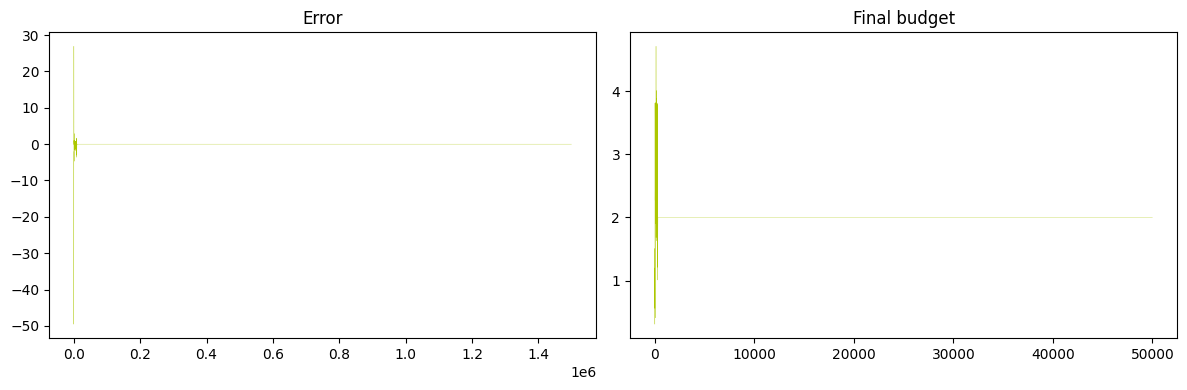

In [62]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
sns.lineplot(x=range(len(training_error)), y=training_error, ax=ax[0], c='#acc700', linewidth=.2)
ax[0].set_title('Error')
sns.lineplot(x=range(len(final_budget_queue)), y=final_budget_queue, ax=ax[1], c='#acc700', linewidth=.2)
ax[1].set_title('Final budget')
plt.tight_layout()
plt.show()

In [64]:
n_episodes_2plus = np.where(np.array(final_budget_queue) > 2)[0].size
print(f'Number of episodes with final budget > 2: {n_episodes_2plus} over 50000')

Number of episodes with final budget > 2: 270 over 50000


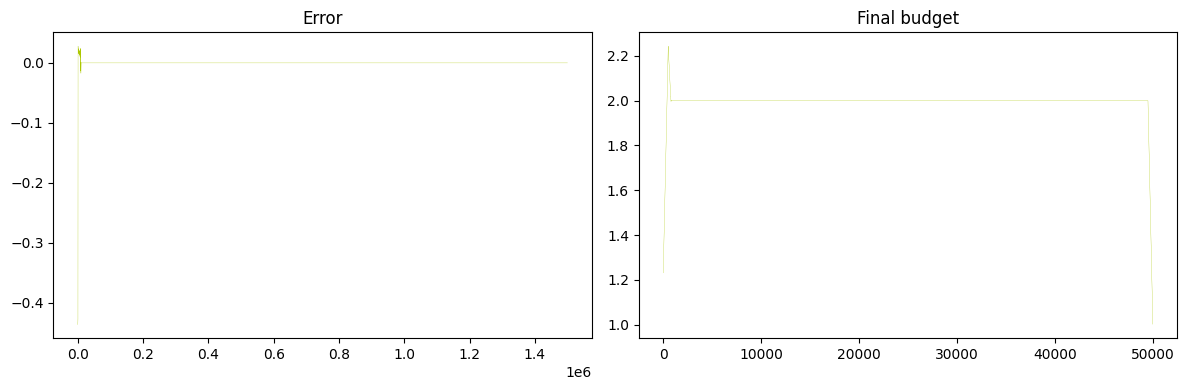

In [65]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=2)
sns.lineplot(x=range(len(error)), y=error, ax=ax[0], c='#acc700', linewidth=.2)
ax[0].set_title('Error')
sns.lineplot(x=range(len(final_budgets)), y=final_budgets, ax=ax[1], c='#acc700', linewidth=.2)
ax[1].set_title('Final budget')
plt.tight_layout()
plt.show()